# Importing Modules

The necessary modules are : os, opencv, numpy, tqdm, matplotlib, keras and sklearn

In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, BatchNormalization, Activation, add
from keras.models import Model, model_from_json
from keras.optimizers import Adam
from keras.layers.advanced_activations import ELU, LeakyReLU
from keras.utils.vis_utils import plot_model
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import json
%matplotlib inline

Using Theano backend.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
import tensorflow as tf

In [3]:
# check if GPU is available
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
tf.test.gpu_device_name()

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17348795195944288282
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 9692625101
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8033759710335562947
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


'/device:GPU:0'

# Constructing Training and Test Datasets

## Loading the Images

We first load all the images and the corresponding segmentation masks. 

They are stored in two lists X, Y and respectively

Moreover, the images are resized to 256x192

In [4]:
X = []
Y = []
n_classes = 5
 
for scan_dir in ['scan30','scan31','scan32']:
    image_idx = 0

    img_dir = "E:\YKL\Thorlabs VSCAN Labeling\{}".format(scan_dir)
    label_dir = "E:\YKL\Thorlabs VSCAN Labeling\{}\LabelingProject\GroundTruthProject\PixelLabelData".format(scan_dir)

    img_files = next(os.walk(img_dir))[2]
    msk_files = next(os.walk(label_dir))[2]

    img_files.sort()
    msk_files.sort()

    print(len(img_files))
    print(len(msk_files))

    for img_fl in tqdm(img_files):    
        if(img_fl.split('.')[-1]=='png'):
            image_idx += 1

            img = cv2.imread('{}\{}'.format(img_dir,img_fl), cv2.IMREAD_GRAYSCALE)

    #         print('E:\YKL\Thorlabs VSCAN Labeling\scan30\{}'.format(img_fl))
            resized_img = cv2.equalizeHist(np.clip(cv2.resize(img,(400, 352), interpolation = cv2.INTER_NEAREST),0,255))
            resized_denoised_img = cv2.fastNlMeansDenoising(resized_img,10,7,21)

            X.append(resized_denoised_img)

            msk = cv2.imread('{}\Label_{}_{}'.format(label_dir,image_idx,img_fl.split('.')[0]+'.png'), cv2.IMREAD_GRAYSCALE)
            resized_msk = np.clip(cv2.resize(msk,(400, 352), interpolation = cv2.INTER_NEAREST),0,4)

            # additional post processing for one hot encoding mask
            resized_msk[resized_msk==0] = 6;
            resized_msk_one_hot = np.zeros((resized_msk.shape[0], resized_msk.shape[1], n_classes))
            for i, unique_value in enumerate(np.unique(resized_msk)):
                resized_msk_one_hot[:, :, i][resized_msk == unique_value] = 1

            Y.append(resized_msk_one_hot)
        

64
63


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:32<00:00,  1.98it/s]


76
76


100%|██████████████████████████████████████████████████████████████████████████████████| 76/76 [00:39<00:00,  1.95it/s]


68
68


100%|██████████████████████████████████████████████████████████████████████████████████| 68/68 [00:34<00:00,  1.95it/s]


## Testing different variations of preprocessing

In [5]:
# uncomment for testing

# img = cv2.imread('E:\YKL\Thorlabs VSCAN Labeling\scan30\VSCAN_0030_150.png', cv2.IMREAD_GRAYSCALE)
# # plt.subplot(1,4,1)
# # plt.imshow(img)
# plt.figure(figsize=(20,10))
# plt.subplot(1,3,1)
# img2 = np.clip(cv2.resize(cv2.fastNlMeansDenoising(img2,200,7,21),(400, 352), interpolation = cv2.INTER_NEAREST),0,255)
# plt.imshow(img2)

# plt.subplot(1,3,2)
# img2 = cv2.equalizeHist(img2)
# plt.imshow(img2)

# # plt.subplot(1,3,3)
# # img2 = cv2.fastNlMeansDenoising(img2,200,7,21)
# # plt.imshow(img2)

## Train-Test Split

The X, Y lists are converted to numpy arrays for convenience. 
Furthermore, the images are divided by 255 to bring down the pixel values to [0...1] range. On the other hand the segmentations masks are converted to binary (0 or 1) values.

Using Sklearn *train_test_split* we split the data randomly into 80% training and 20% testing data

In [5]:
print(len(X))
print(len(Y))

X = np.array(X)
X = X[:, :, :, np.newaxis]
Y = np.array(Y)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=3)

Y_train = Y_train.reshape((Y_train.shape[0],Y_train.shape[1],Y_train.shape[2],5))
Y_test = Y_test.reshape((Y_test.shape[0],Y_test.shape[1],Y_test.shape[2],5))

X_train = X_train / 255
X_test = X_test / 255
Y_train = Y_train
Y_test = Y_test

Y_train = np.round(Y_train,0)
Y_test = np.round(Y_test,0)

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)


207
207
(165, 352, 400, 1)
(165, 352, 400, 5)
(42, 352, 400, 1)
(42, 352, 400, 5)


## Display one image from test

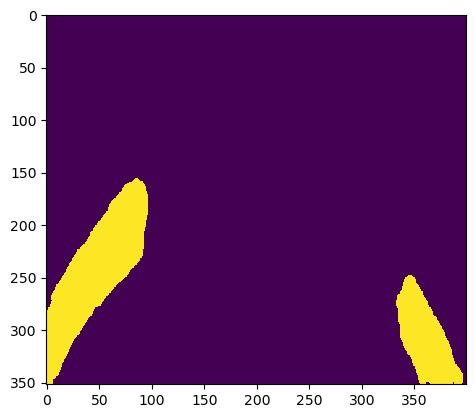

In [6]:
%matplotlib inline
plt.imshow(Y_test[1][:,:,1])

## Form segmented images from one hot encoding

In [4]:
def one_hot_to_seg(img_lst_one_hot):
    img_lst_new = []
    for one_hot_img in range(len(img_lst_one_hot)):
        img_new = np.copy(img_lst_one_hot[one_hot_img])
        for lbl in range(0,5):
            img_new[:,:,lbl]*=lbl*255/5
        img_lst_new.append(np.sum(img_new,axis=2))
    return img_lst_new

In [9]:
Y_test_disp = one_hot_to_seg(Y_test)

# MultiResUNet Model

## Model Definition

The MultiResUNet model as described in the [paper](https://arxiv.org/abs/1902.04049) can be found  [here](https://github.com/nibtehaz/MultiResUNet/blob/master/MultiResUNet.py)

In [5]:
def conv2d_bn(x, filters, num_row, num_col, padding='same', strides=(1, 1), activation='relu', name=None):
    '''
    2D Convolutional layers
    
    Arguments:
        x {keras layer} -- input layer 
        filters {int} -- number of filters
        num_row {int} -- number of rows in filters
        num_col {int} -- number of columns in filters
    
    Keyword Arguments:
        padding {str} -- mode of padding (default: {'same'})
        strides {tuple} -- stride of convolution operation (default: {(1, 1)})
        activation {str} -- activation function (default: {'relu'})
        name {str} -- name of the layer (default: {None})
    
    Returns:
        [keras layer] -- [output layer]
    '''

    x = Conv2D(filters, (num_row, num_col), strides=strides, padding=padding, use_bias=False)(x)
    x = BatchNormalization(axis=3, scale=False)(x)

    if(activation == None):
        return x

    x = Activation(activation, name=name)(x)

    return x


def trans_conv2d_bn(x, filters, num_row, num_col, padding='same', strides=(2, 2), name=None):
    '''
    2D Transposed Convolutional layers
    
    Arguments:
        x {keras layer} -- input layer 
        filters {int} -- number of filters
        num_row {int} -- number of rows in filters
        num_col {int} -- number of columns in filters
    
    Keyword Arguments:
        padding {str} -- mode of padding (default: {'same'})
        strides {tuple} -- stride of convolution operation (default: {(2, 2)})
        name {str} -- name of the layer (default: {None})
    
    Returns:
        [keras layer] -- [output layer]
    '''

    x = Conv2DTranspose(filters, (num_row, num_col), strides=strides, padding=padding)(x)
    x = BatchNormalization(axis=3, scale=False)(x)
    
    return x


def MultiResBlock(U, inp, alpha = 1.67):
    '''
    MultiRes Block
    
    Arguments:
        U {int} -- Number of filters in a corrsponding UNet stage
        inp {keras layer} -- input layer 
    
    Returns:
        [keras layer] -- [output layer]
    '''

    W = alpha * U

    shortcut = inp

    shortcut = conv2d_bn(shortcut, int(W*0.167) + int(W*0.333) +
                         int(W*0.5), 1, 1, activation=None, padding='same')

    conv3x3 = conv2d_bn(inp, int(W*0.167), 3, 3,
                        activation='relu', padding='same')

    conv5x5 = conv2d_bn(conv3x3, int(W*0.333), 3, 3,
                        activation='relu', padding='same')

    conv7x7 = conv2d_bn(conv5x5, int(W*0.5), 3, 3,
                        activation='relu', padding='same')

    out = concatenate([conv3x3, conv5x5, conv7x7], axis=3)
    out = BatchNormalization(axis=3)(out)

    out = add([shortcut, out])
    out = Activation('relu')(out)
    out = BatchNormalization(axis=3)(out)

    return out


def ResPath(filters, length, inp):
    '''
    ResPath
    
    Arguments:
        filters {int} -- [description]
        length {int} -- length of ResPath
        inp {keras layer} -- input layer 
    
    Returns:
        [keras layer] -- [output layer]
    '''


    shortcut = inp
    shortcut = conv2d_bn(shortcut, filters, 1, 1,
                         activation=None, padding='same')

    out = conv2d_bn(inp, filters, 3, 3, activation='relu', padding='same')

    out = add([shortcut, out])
    out = Activation('relu')(out)
    out = BatchNormalization(axis=3)(out)

    for i in range(length-1):

        shortcut = out
        shortcut = conv2d_bn(shortcut, filters, 1, 1,
                             activation=None, padding='same')

        out = conv2d_bn(out, filters, 3, 3, activation='relu', padding='same')

        out = add([shortcut, out])
        out = Activation('relu')(out)
        out = BatchNormalization(axis=3)(out)

    return out


def MultiResUnet(height, width, n_channels):
    '''
    MultiResUNet
    
    Arguments:
        height {int} -- height of image 
        width {int} -- width of image 
        n_channels {int} -- number of channels in image
    
    Returns:
        [keras model] -- MultiResUNet model
    '''


    inputs = Input((height, width, n_channels))

    mresblock1 = MultiResBlock(32, inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(mresblock1)
    mresblock1 = ResPath(32, 4, mresblock1)

    mresblock2 = MultiResBlock(32*2, pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(mresblock2)
    mresblock2 = ResPath(32*2, 3, mresblock2)

    mresblock3 = MultiResBlock(32*4, pool2)
    pool3 = MaxPooling2D(pool_size=(2, 2))(mresblock3)
    mresblock3 = ResPath(32*4, 2, mresblock3)

    mresblock4 = MultiResBlock(32*8, pool3)
    pool4 = MaxPooling2D(pool_size=(2, 2))(mresblock4)
    mresblock4 = ResPath(32*8, 1, mresblock4)

    mresblock5 = MultiResBlock(32*16, pool4)

    up6 = concatenate([Conv2DTranspose(
        32*8, (2, 2), strides=(2, 2), padding='same')(mresblock5), mresblock4], axis=3)
    mresblock6 = MultiResBlock(32*8, up6)

    up7 = concatenate([Conv2DTranspose(
        32*4, (2, 2), strides=(2, 2), padding='same')(mresblock6), mresblock3], axis=3)
    mresblock7 = MultiResBlock(32*4, up7)

    up8 = concatenate([Conv2DTranspose(
        32*2, (2, 2), strides=(2, 2), padding='same')(mresblock7), mresblock2], axis=3)
    mresblock8 = MultiResBlock(32*2, up8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(
        2, 2), padding='same')(mresblock8), mresblock1], axis=3)
    mresblock9 = MultiResBlock(32, up9)

    conv10 = conv2d_bn(mresblock9, 5, 1, 1, activation='sigmoid')
    
    model = Model(inputs=[inputs], outputs=[conv10])

    return model


## Auxiliary Functions

### Custom Metrics

Since Keras does not have build-in support for computing Dice Coefficient or Jaccard Index (at the time of writing), the following functions are declared

In [11]:
# def dice_coef(y_true, y_pred):
#     smooth = 0.0
#     y_true_f = K.flatten(y_true)
#     y_pred_f = K.flatten(y_pred)
#     intersection = K.sum(y_true_f * y_pred_f)
#     return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# def jacard(y_true, y_pred):

#     y_true_f = K.flatten(y_true)
#     y_pred_f = K.flatten(y_pred)
#     intersection = K.sum ( y_true_f * y_pred_f)
#     union = K.sum ( y_true_f + y_pred_f - y_true_f * y_pred_f)

#     return intersection/union

### Saving Model 

Function to save the model

In [6]:
def saveModel(model):

    model_json = model.to_json()

    try:
        os.makedirs('models')
    except:
        pass
    
    fp = open('models/modelP.json','w')
    fp.write(model_json)
    model.save_weights('models/modelW.h5')


### Evaluate the Model

We evaluate the model on test data (X_test, Y_test). 

We compute the values of Jaccard Index and Dice Coeficient, and save the predicted segmentation of first 10 images. The best model is also saved

(This could have been done using keras call-backs as well)

In [7]:
def evaluateModel(model, X_test, Y_test, batchSize):
    
    try:
        os.makedirs('results')
    except:
        pass 
    

    yp = model.predict(x=X_test, batch_size=batchSize, verbose=1)

    yp = np.round(yp,0)
    
    yp_disp = one_hot_to_seg(yp)

    for i in range(10):

        plt.figure(figsize=(20,10))
        plt.subplot(1,3,1)
        plt.imshow(np.squeeze(X_test[i],axis=2))
        plt.title('Input')
        plt.subplot(1,3,2)
        #TODO: show segmented Y
        plt.imshow(Y_test_disp[i].reshape(Y_test[i].shape[0],Y_test[i].shape[1]))
        plt.title('Ground Truth')
        plt.subplot(1,3,3)
        plt.imshow(yp_disp[i].reshape(yp[i].shape[0],yp[i].shape[1]))
        plt.title('Prediction')

        intersection = yp[i].ravel() * Y_test[i].ravel()
        union = yp[i].ravel() + Y_test[i].ravel() - intersection

        jacard = (np.sum(intersection)/np.sum(union))  
        plt.suptitle('Jacard Index'+ str(np.sum(intersection)) +'/'+ str(np.sum(union)) +'='+str(jacard))

        plt.savefig('results/'+str(i)+'.png',format='png')
        plt.close()


    jacard = 0
    dice = 0
    
    
    for i in range(len(Y_test)):
        yp_2 = yp[i].ravel()
        y2 = Y_test[i].ravel()
        
        intersection = yp_2 * y2
        union = yp_2 + y2 - intersection

        jacard += (np.sum(intersection)/np.sum(union))  

        dice += (2. * np.sum(intersection) ) / (np.sum(yp_2) + np.sum(y2))

    
    jacard /= len(Y_test)
    dice /= len(Y_test)
    


    print('Jacard Index : '+str(jacard))
    print('Dice Coefficient : '+str(dice))
    

    fp = open('models/log.txt','a')
    fp.write(str(jacard)+'\n')
    fp.close()

    fp = open('models/best.txt','r')
    best = fp.read()
    fp.close()

    if(jacard>float(best)):
        print('***********************************************')
        print('Jacard Index improved from '+str(best)+' to '+str(jacard))
        print('***********************************************')
        fp = open('models/best.txt','w')
        fp.write(str(jacard))
        fp.close()

        saveModel(model)


### Training the Model

The model is trained and evaluated after each epochs

In [8]:
def trainStep(model, X_train, Y_train, X_test, Y_test, epochs, batchSize):

    
    for epoch in range(epochs):
        print('Epoch : {}'.format(epoch+1))
        model.fit(x=X_train, y=Y_train, batch_size=batchSize, epochs=1, verbose=1)     

        evaluateModel(model,X_test, Y_test,batchSize)

    return model 

## Define Model, Train and Evaluate

In [17]:
model = MultiResUnet(height=352, width=400, n_channels=1)

# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef, jacard, 'categorical_accuracy'])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['categorical_accuracy'])

saveModel(model)

fp = open('models/log.txt','w')
fp.close()
fp = open('models/best.txt','w')
fp.write('-1.0')
fp.close()
    
trainStep(model, X_train, Y_train, X_test, Y_test, epochs=60, batchSize=3)

Epoch : 1
Epoch 1/1
42/42 [==============================] - ETA: 30 - ETA: 14 - ETA: 9 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 4s 90ms/step
Jacard Index : 0.043349408891175036
Dice Coefficient : 0.08305895833308916
***********************************************
Jacard Index improved from -1.0 to 0.043349408891175036
***********************************************
Epoch : 2
Epoch 1/1
42/42 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 2s 37ms/step
Jacard Index : 0.08249250386707001
Dice Coefficient : 0.1523117427891751
***********************************************
Jacard Index improved from 0.043349408891175036 to 0.08249250386707001
***********************************************
Epoch : 3
Epoch 1/1
42/42 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 2s 37ms

42/42 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 2s 37ms/step
Jacard Index : 0.06459798122502465
Dice Coefficient : 0.12122186344207586
Epoch : 6
Epoch 1/1
42/42 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 2s 37ms/step
Jacard Index : 0.0805223187135015
Dice Coefficient : 0.14886553715861695
Epoch : 7
Epoch 1/1
42/42 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 2s 37ms/step
Jacard Index : 0.15295748906297782
Dice Coefficient : 0.2649334691050765
***********************************************
Jacard Index improved from 0.08249250386707001 to 0.15295748906297782
***********************************************
Epoch : 8
Epoch 1/1
42/42 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  -

42/42 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 2s 38ms/step
Jacard Index : 0.3731402070441997
Dice Coefficient : 0.5406499841475686
***********************************************
Jacard Index improved from 0.15295748906297782 to 0.3731402070441997
***********************************************
Epoch : 10
Epoch 1/1
42/42 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 2s 37ms/step
Jacard Index : 0.7316366948424915
Dice Coefficient : 0.8428036254486125
***********************************************
Jacard Index improved from 0.3731402070441997 to 0.7316366948424915
***********************************************
Epoch : 11
Epoch 1/1
42/42 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 2s 38ms/step
Jacard Inde

42/42 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 2s 37ms/step
Jacard Index : 0.5571688969357791
Dice Coefficient : 0.7090046766604446
Epoch : 14
Epoch 1/1
42/42 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 2s 37ms/step
Jacard Index : 0.8600367312728912
Dice Coefficient : 0.9245314888330567
***********************************************
Jacard Index improved from 0.8022318952148881 to 0.8600367312728912
***********************************************
Epoch : 15
Epoch 1/1
42/42 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 2s 38ms/step
Jacard Index : 0.9548451803981763
Dice Coefficient : 0.9768689366609268
***********************************************
Jacard Index improved from 0.8600367312728912 to 0.95484

42/42 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 2s 38ms/step
Jacard Index : 0.9107608895202726
Dice Coefficient : 0.9529355642673049
Epoch : 18
Epoch 1/1
42/42 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 2s 37ms/step
Jacard Index : 0.959251049589178
Dice Coefficient : 0.9791857595682426
***********************************************
Jacard Index improved from 0.9548451803981763 to 0.959251049589178
***********************************************
Epoch : 19
Epoch 1/1
42/42 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 2s 38ms/step
Jacard Index : 0.9593362911538577
Dice Coefficient : 0.9792260747983813
***********************************************
Jacard Index improved from 0.959251049589178 to 0.95933629

42/42 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 2s 37ms/step
Jacard Index : 0.9279646133129811
Dice Coefficient : 0.9624589041743177
Epoch : 22
Epoch 1/1
42/42 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 2s 37ms/step
Jacard Index : 0.9418222441471452
Dice Coefficient : 0.9699211083520247
Epoch : 23
Epoch 1/1
42/42 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 2s 37ms/step
Jacard Index : 0.9603728186177068
Dice Coefficient : 0.9797673641838076
***********************************************
Jacard Index improved from 0.9593362911538577 to 0.9603728186177068
***********************************************
Epoch : 24
Epoch 1/1
42/42 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ET

42/42 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 2s 37ms/step
Jacard Index : 0.9608821291054822
Dice Coefficient : 0.980033211322357
***********************************************
Jacard Index improved from 0.9603728186177068 to 0.9608821291054822
***********************************************
Epoch : 26
Epoch 1/1
42/42 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 2s 37ms/step
Jacard Index : 0.9602730073810726
Dice Coefficient : 0.9797153268218116
Epoch : 27
Epoch 1/1
42/42 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 2s 37ms/step
Jacard Index : 0.9600956627221232
Dice Coefficient : 0.9796208593165157
Epoch : 28
Epoch 1/1
42/42 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA

42/42 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 2s 37ms/step
Jacard Index : 0.9082873053880322
Dice Coefficient : 0.9517612571514337
Epoch : 30
Epoch 1/1
42/42 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 2s 37ms/step
Jacard Index : 0.8522149167547084
Dice Coefficient : 0.9197635222968769
Epoch : 31
Epoch 1/1
42/42 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 2s 37ms/step
Jacard Index : 0.9561818308795206
Dice Coefficient : 0.9775752184866294
Epoch : 32
Epoch 1/1
42/42 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 2s 37ms/step
Jacard Index : 0.9580088979505599
Dice Coefficient : 0.9785310442865264
Epoch : 33
Epoch 

42/42 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 2s 37ms/step
Jacard Index : 0.9590259027828895
Dice Coefficient : 0.9790643130634817
Epoch : 34
Epoch 1/1
42/42 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 2s 37ms/step
Jacard Index : 0.9582031604255422
Dice Coefficient : 0.9786312681635204
Epoch : 35
Epoch 1/1
42/42 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 2s 37ms/step
Jacard Index : 0.9542548200236777
Dice Coefficient : 0.9765578226927472
Epoch : 36
Epoch 1/1
42/42 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 2s 37ms/step
Jacard Index : 0.9556236771620641
Dice Coefficient : 0.9772806575610257
Epoch : 37
Epoch 

42/42 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 2s 37ms/step
Jacard Index : 0.9536358517173951
Dice Coefficient : 0.9762183398271634
Epoch : 38
Epoch 1/1
42/42 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 2s 37ms/step
Jacard Index : 0.9582371363323384
Dice Coefficient : 0.9786539686231299
Epoch : 39
Epoch 1/1
42/42 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 2s 37ms/step
Jacard Index : 0.9584779654854452
Dice Coefficient : 0.9787812187283733
Epoch : 40
Epoch 1/1
42/42 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 2s 37ms/step
Jacard Index : 0.9588889332117833
Dice Coefficient : 0.978993495938378
Epoch : 41
Epoch 1

42/42 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 2s 38ms/step
Jacard Index : 0.9598700222306198
Dice Coefficient : 0.9795064412066662
Epoch : 42
Epoch 1/1
42/42 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 2s 37ms/step
Jacard Index : 0.9593835049704906
Dice Coefficient : 0.9792508499917031
Epoch : 43
Epoch 1/1
42/42 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 2s 37ms/step
Jacard Index : 0.956459392693825
Dice Coefficient : 0.9777217989853119
Epoch : 44
Epoch 1/1
42/42 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 2s 37ms/step
Jacard Index : 0.9585306562029132
Dice Coefficient : 0.9788077970326627
Epoch : 45
Epoch 1

42/42 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 2s 37ms/step
Jacard Index : 0.9584877509668394
Dice Coefficient : 0.9787836911440877
Epoch : 46
Epoch 1/1
42/42 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 2s 37ms/step
Jacard Index : 0.9584616193205364
Dice Coefficient : 0.9787712202842594
Epoch : 47
Epoch 1/1
42/42 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 2s 37ms/step
Jacard Index : 0.957947530720151
Dice Coefficient : 0.9785028494484715
Epoch : 48
Epoch 1/1
42/42 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 2s 37ms/step
Jacard Index : 0.9558369513290875
Dice Coefficient : 0.9773994544685527
Epoch : 49
Epoch 1

42/42 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 2s 37ms/step
Jacard Index : 0.538632769118078
Dice Coefficient : 0.6996207647823282
Epoch : 50
Epoch 1/1
42/42 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 2s 37ms/step
Jacard Index : 0.8472447829392936
Dice Coefficient : 0.9170151139970631
Epoch : 51
Epoch 1/1
42/42 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 2s 37ms/step
Jacard Index : 0.9384216098464966
Dice Coefficient : 0.9681101735448701
Epoch : 52
Epoch 1/1
42/42 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 2s 37ms/step
Jacard Index : 0.9584507428703891
Dice Coefficient : 0.9787668981632403
Epoch : 53
Epoch 1

42/42 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 2s 37ms/step
Jacard Index : 0.937539957156123
Dice Coefficient : 0.9675948737801311
Epoch : 54
Epoch 1/1
42/42 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 2s 37ms/step
Jacard Index : 0.9577035250027579
Dice Coefficient : 0.978380932835354
Epoch : 55
Epoch 1/1
42/42 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 2s 37ms/step
Jacard Index : 0.95715097989842
Dice Coefficient : 0.9780943683557894
Epoch : 56
Epoch 1/1
42/42 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 2s 37ms/step
Jacard Index : 0.9591116870384458
Dice Coefficient : 0.9791131128959698
Epoch : 57
Epoch 1/1


42/42 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 2s 37ms/step
Jacard Index : 0.9529560011795477
Dice Coefficient : 0.9758883783725106
Epoch : 58
Epoch 1/1
42/42 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 2s 37ms/step
Jacard Index : 0.9582732568420951
Dice Coefficient : 0.9786788003792564
Epoch : 59
Epoch 1/1
42/42 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 2s 37ms/step
Jacard Index : 0.9551655744651761
Dice Coefficient : 0.977050677353117
Epoch : 60
Epoch 1/1
42/42 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 2s 37ms/step
Jacard Index : 0.9573552103011864
Dice Coefficient : 0.9781949561714581


## Load Best Model

In [ ]:
model = MultiResUnet(height=352, width=400, n_channels=1)
!pip install 'h5py==2.9.0' --force-reinstall
model.load_weights("models/modelW.h5")

## Try on training data for sanity check

165/165 [==============================] - ETA: 48 - ETA: 20 - ETA: 14 - ETA: 12 - ETA: 10 - ETA: 9 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 7s 42ms/step


Text(0.5, 1.0, 'Prediction')

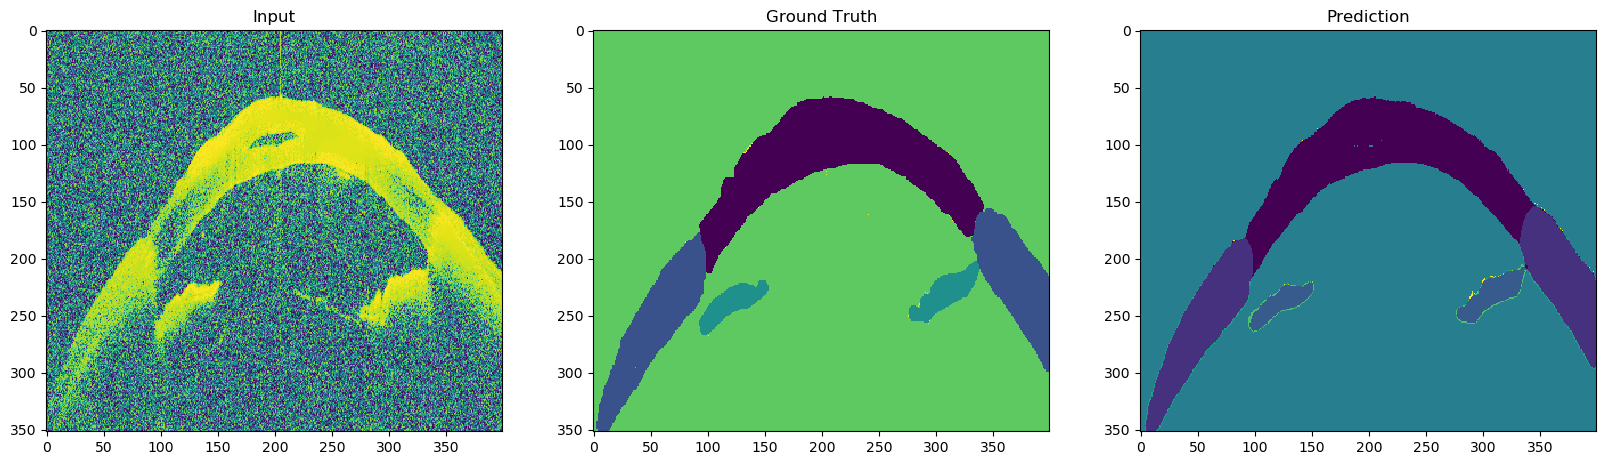

In [18]:
yp = model.predict(x=X_train, batch_size=1, verbose=1)
yp = np.round(yp,0)    
yp_disp = one_hot_to_seg(yp)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(np.squeeze(X_train[0],axis=2))
plt.title('Input')
plt.subplot(1,3,2)

plt.imshow(one_hot_to_seg(Y_train)[0].reshape(Y_test[0].shape[0],Y_test[0].shape[1]))
plt.title('Ground Truth')
plt.subplot(1,3,3)
plt.imshow(yp_disp[0].reshape(yp[0].shape[0],yp[0].shape[1]))
plt.title('Prediction')

## Try on One Image from Test Data

42/42 [==============================] - ETA: 12 - ETA: 7 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 2s 47ms/step


Text(0.5, 1.0, 'Prediction')

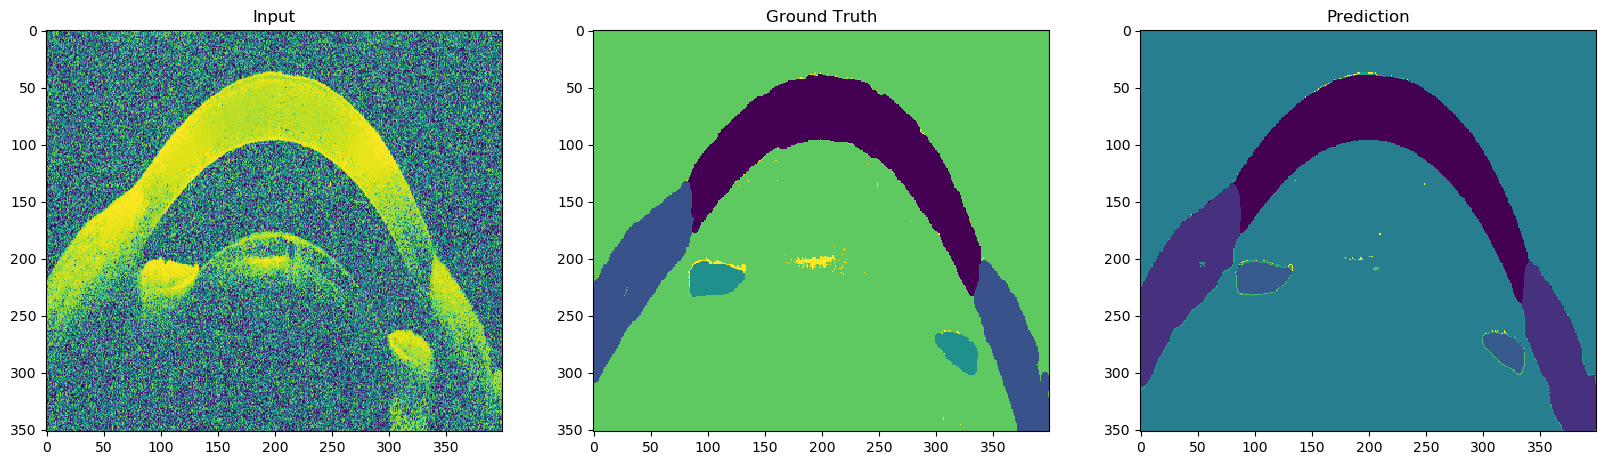

In [19]:
yp = model.predict(x=X_test, batch_size=1, verbose=1)
yp = np.round(yp,0)    
yp_disp = one_hot_to_seg(yp)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(np.squeeze(X_test[0],axis=2))
plt.title('Input')
plt.subplot(1,3,2)

plt.imshow(one_hot_to_seg(Y_test)[0].reshape(Y_test[0].shape[0],Y_test[0].shape[1]))
plt.title('Ground Truth')
plt.subplot(1,3,3)
plt.imshow(yp_disp[0].reshape(yp[0].shape[0],yp[0].shape[1]))
plt.title('Prediction')

Text(0.5, 1.0, 'Prediction')

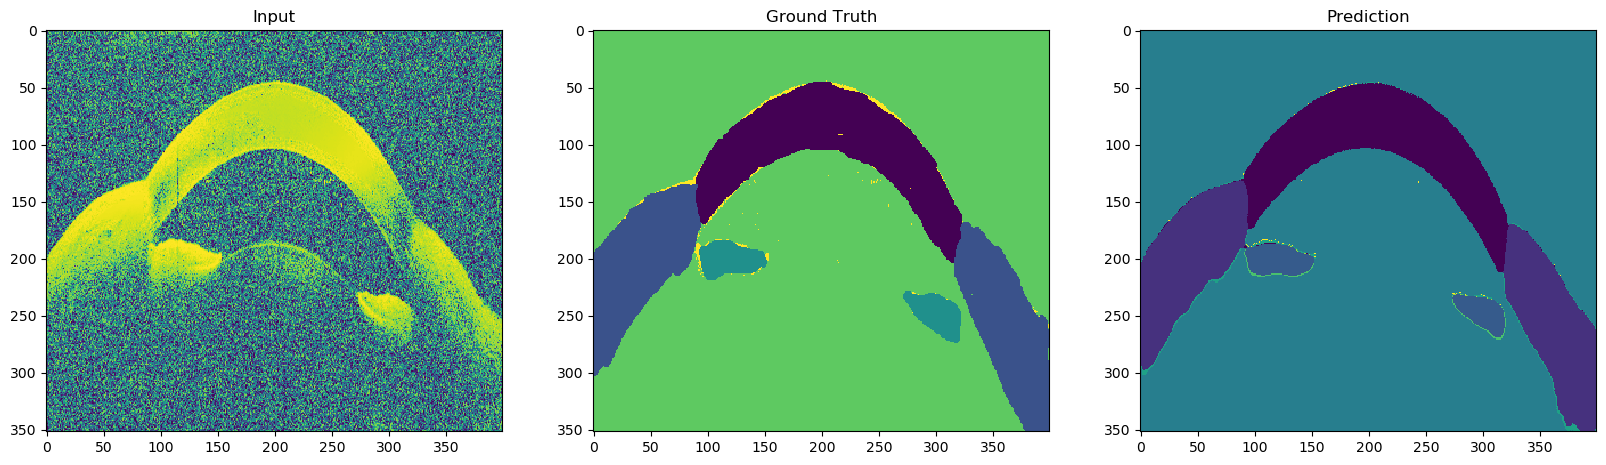

In [32]:
img_no = 11

plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(np.squeeze(X_test[img_no],axis=2))
plt.title('Input')
plt.subplot(1,3,2)

plt.imshow(one_hot_to_seg(Y_test)[img_no].reshape(Y_test[0].shape[0],Y_test[0].shape[1]))
plt.title('Ground Truth')
plt.subplot(1,3,3)
plt.imshow(yp_disp[img_no].reshape(yp[0].shape[0],yp[0].shape[1]))
plt.title('Prediction')

## Try on never seen test data

### Preprocess Part 1

In [39]:
X_test_test = []
Y_test_test = []

img = cv2.imread("E:\YKL\Thorlabs VSCAN Labeling\scan27\VSCAN_0027_190.png", cv2.IMREAD_GRAYSCALE)

#         print('E:\YKL\Thorlabs VSCAN Labeling\scan30\{}'.format(img_fl))
resized_img = cv2.equalizeHist(np.clip(cv2.resize(img,(400, 352), interpolation = cv2.INTER_NEAREST),0,255))
resized_denoised_img = cv2.fastNlMeansDenoising(resized_img,10,7,21)

X_test_test.append(resized_denoised_img)

msk = cv2.imread("E:\YKL\Thorlabs VSCAN Labeling\scan27\LabelingProject\GroundTruthProject\PixelLabelData\Label_1_VSCAN_0027_190.png", cv2.IMREAD_GRAYSCALE)
resized_msk = np.clip(cv2.resize(msk,(400, 352), interpolation = cv2.INTER_NEAREST),0,4)

# additional post processing for one hot encoding mask
resized_msk[resized_msk==0] = 6;
resized_msk_one_hot = np.zeros((resized_msk.shape[0], resized_msk.shape[1], n_classes))
for i, unique_value in enumerate(np.unique(resized_msk)):
    resized_msk_one_hot[:, :, i][resized_msk == unique_value] = 1

Y_test_test.append(resized_msk_one_hot)

In [ ]:
plt.imshow(Y_test_test[0][:,:,2])

### Preprocess part 2

In [40]:
X_test_test = np.array(X_test_test)
X_test_test = X_test_test[:, :, :, np.newaxis]
X_test_test = X_test_test / 255

### Prediction

In [44]:
yp_test = model.predict(x=X_test_test, batch_size=1, verbose=1)
yp_test = np.round(yp_test,0)    
yp_test_disp = one_hot_to_seg(yp_test)

1/1 [==============================] - 0s 329ms/step


### Show result

Text(0.5, 1.0, 'Prediction')

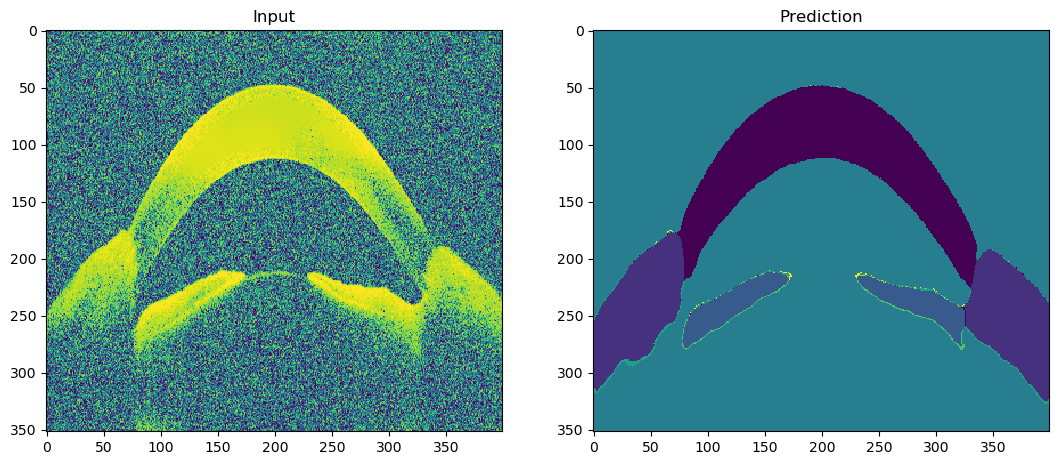

In [45]:
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(np.squeeze(X_test_test[0],axis=2))
plt.title('Input')
plt.subplot(1,3,2)
plt.imshow(yp_test_disp[0].reshape(yp[0].shape[0],yp[0].shape[1]))
plt.title('Prediction')